# Import Modules

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
#from tensorflow.keras.optimizers import SGD
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from PIL import Image
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Load the dataset

In [2]:
BASE_DIR = r'C:/Users/sebas/OneDrive/Desktop/ProyectoIA/UTKFace'

In [3]:
#labels age, gender, ethinicity
image_paths = []
age_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR,filename)
    temp = filename.split("_")
    age = int(temp[0])
    image_paths.append(image_path)
    age_labels.append(age)

100%|██████████| 23708/23708 [00:00<00:00, 201012.27it/s]


In [4]:
#convert to dataframe
df = pd.DataFrame()
df['image'] = image_paths
df['age'] = age_labels
df.head()

,image,age
0,C:/Users/sebas/OneDrive/Desktop/ProyectoIA/UTK...,100
1,C:/Users/sebas/OneDrive/Desktop/ProyectoIA/UTK...,100
2,C:/Users/sebas/OneDrive/Desktop/ProyectoIA/UTK...,100
3,C:/Users/sebas/OneDrive/Desktop/ProyectoIA/UTK...,100
4,C:/Users/sebas/OneDrive/Desktop/ProyectoIA/UTK...,100


# Exploratory Data Analysis

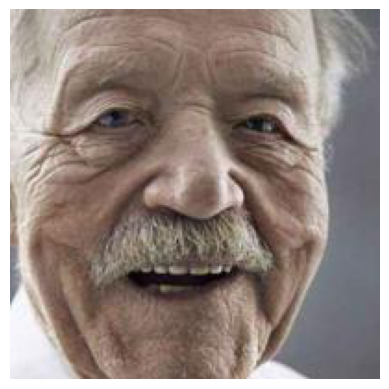

In [5]:
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);
plt.show()

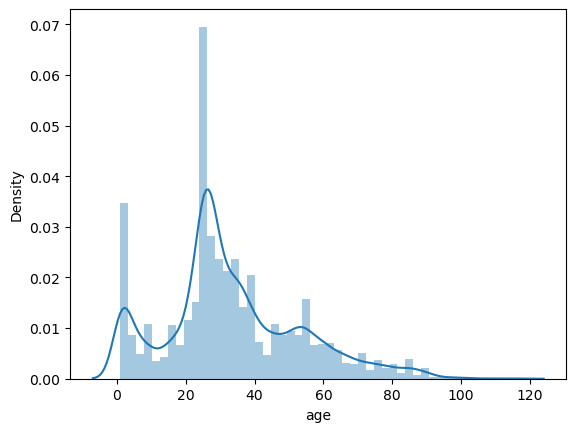

In [6]:
sns.distplot(df['age'])
plt.show()

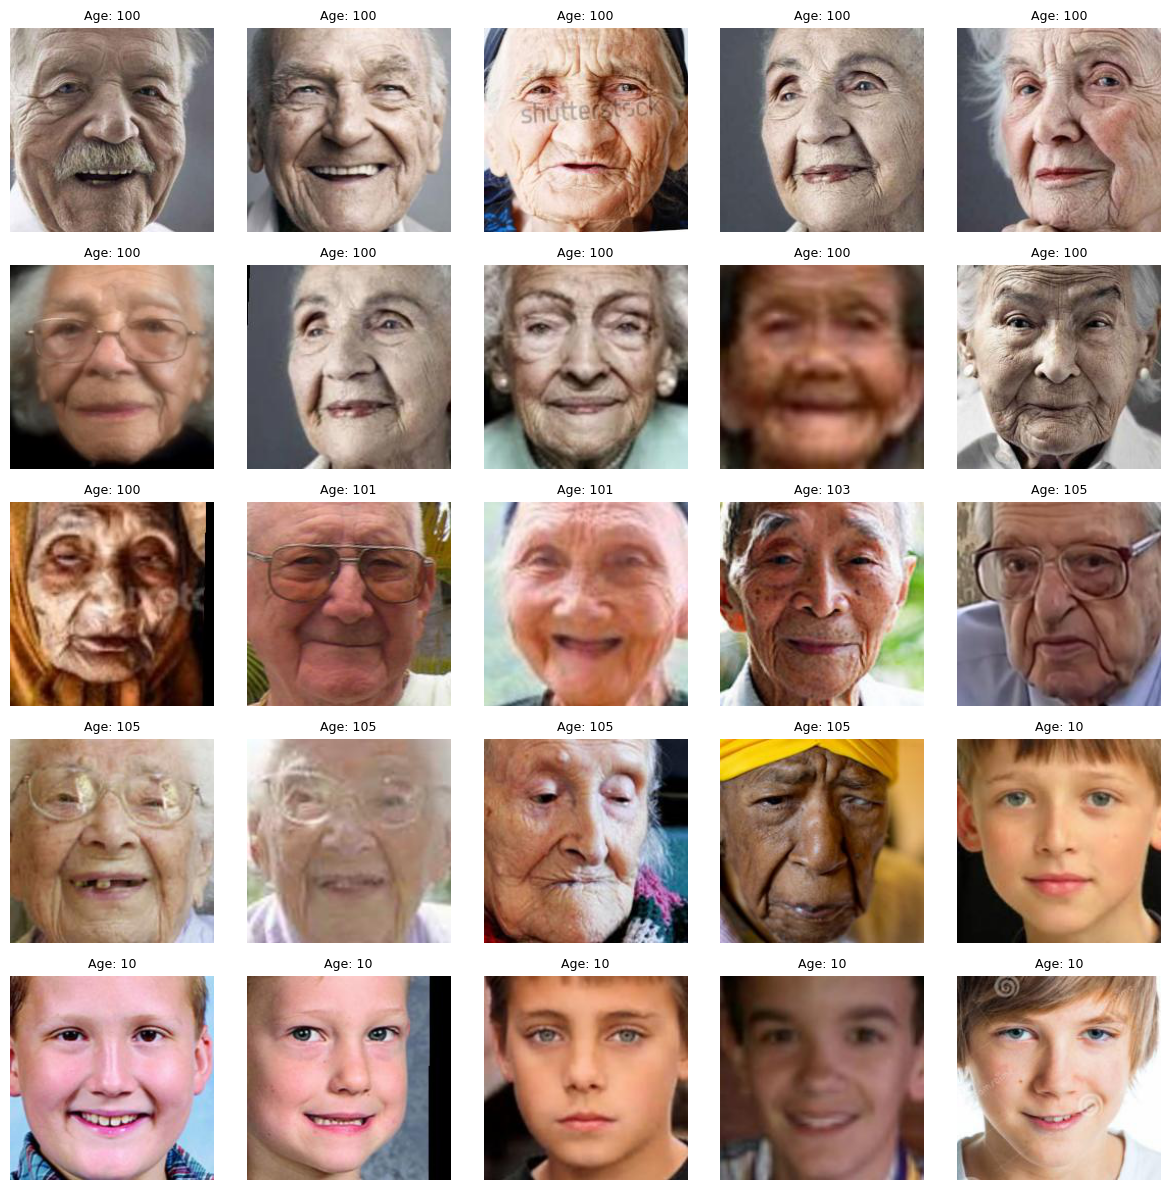

In [7]:
files = df.iloc[:25]  

fig, axes = plt.subplots(5, 5, figsize=(12, 12))  
axes = axes.ravel()  

for i, row in enumerate(files.itertuples(index=False)):  
    img = load_img(row.image)          
    axes[i].imshow(np.array(img))
    axes[i].set_title(f"Age: {row.age}", fontsize=9)
    axes[i].axis('off')

# Oculta ejes sobrantes si <25 imágenes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Feature Extraction

In [8]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def _read_resize(path, size=(128,128), gray=True):
    # cv2.imread devuelve BGR/uint8; con flag 0 lee en gris
    img = cv2.imread(path, 0 if gray else 1)
    if img is None:
        return None  # archivo corrupto o ruta inválida
    # INTER_AREA suele ir bien al reducir; LANCZOS4 para más calidad
    img = cv2.resize(img, size, interpolation=cv2.INTER_LANCZOS4)
    if not gray:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # opcional para mostrar
    return img

def extract_features_cv2(paths, size=(128,128), gray=True, workers=0, normalize=False):
    """
    paths: iterable de rutas (str)
    workers: 0 o 1 => sin paralelismo; >1 usa ThreadPoolExecutor
    normalize: si True, devuelve float32 en [0,1]
    """
    results = []
    if workers and workers > 1:
        with ThreadPoolExecutor(max_workers=workers) as ex:
            futures = {ex.submit(_read_resize, p, size, gray): p for p in paths}
            for f in tqdm(as_completed(futures), total=len(futures)):
                img = f.result()
                if img is not None:
                    results.append(img)
    else:
        for p in tqdm(paths):
            img = _read_resize(p, size, gray)
            if img is not None:
                results.append(img)

    X = np.stack(results, axis=0)  # (N, H, W) o (N, H, W, C)
    if gray:
        X = X[..., np.newaxis]     # (N, H, W, 1)

    if normalize:
        X = (X.astype(np.float32) / 255.0)

    return X

In [9]:
paths = df['image'].tolist()
X = extract_features_cv2(paths, size=(128,128), gray=True, workers=8, normalize=True)
X.shape

100%|██████████| 23708/23708 [00:49<00:00, 482.70it/s] 


(23708, 128, 128, 1)

In [10]:
y_age = np.array(df['age'])

In [11]:
input_shape = (128, 128, 1)

# Model Creation 

In [12]:
inp = Input(shape=input_shape)

aug = layers.RandomFlip("horizontal")(inp)
aug = layers.RandomRotation(0.05)(aug)
aug = layers.RandomZoom(0.1)(aug)
aug = layers.RandomContrast(0.1)(aug)

x = layers.Conv2D(32, 3, padding="same", activation=None)(inp)
x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(64, 3, padding="same", activation=None)(x)
x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(128, 3, padding="same", activation=None)(x)
x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(256, 3, padding="same", activation=None)(x)
x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
x = layers.GlobalAveragePooling2D()(x)    # fewer params than Flatten

x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
out = layers.Dense(1, activation="linear", name="age_out")(x)

model = Model(inp, out)
model.compile(
    optimizer=Adam(1e-3),
    loss=Huber(delta=5.0),
    metrics=["mae"]
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ age_out (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 455,809 (1.74 MB)

 Trainable params: 454,849 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

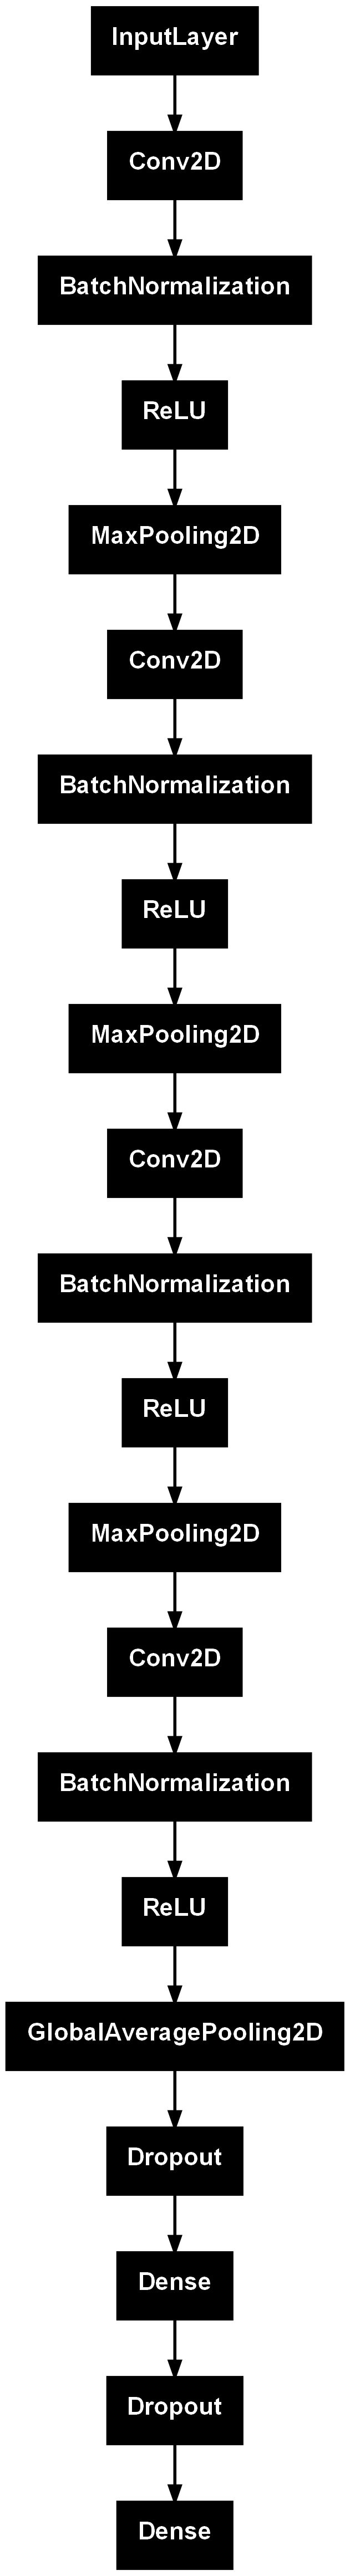

In [13]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [14]:
callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True, monitor="val_mae"),
    ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-5, monitor="val_mae")
]

In [15]:
history = model.fit(
    X, y_age,
    batch_size=96,
    epochs=60,
    validation_split=0.2,
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - loss: 40.6862 - mae: 10.3300 - val_loss: 172.7882 - val_mae: 37.0576 - learning_rate: 0.0010
Epoch 2/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - loss: 32.4886 - mae: 8.6615 - val_loss: 167.3333 - val_mae: 35.9667 - learning_rate: 0.0010
Epoch 3/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - loss: 29.3044 - mae: 7.9978 - val_loss: 107.8260 - val_mae: 24.0608 - learning_rate: 0.0010
Epoch 4/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - loss: 27.2331 - mae: 7.5579 - val_loss: 115.0848 - val_mae: 25.5161 - learning_rate: 0.0010
Epoch 5/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - loss: 25.2988 - mae: 7.1595 - val_loss: 118.8865 - val_mae: 26.2463 - learning_rate: 0.0010
Epoch 6/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 279s 1s/step - loss: 24.2278 - mae: 6.9273 - val_loss: 181.7327 - val_mae: 38.7570 - learning_rate: 0.0010
Epoch 7/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 276s 1s/step - loss: 22.7940 - mae: 6.6277 - val_loss: 123.7557 - val_mae: 27

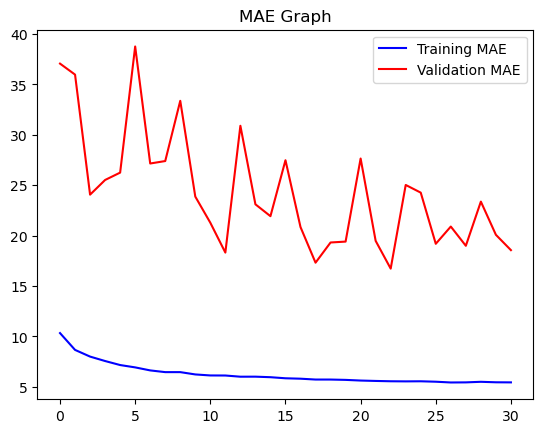

In [16]:
# plot results for age
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('MAE Graph')
plt.legend()
plt.show()

# Prediction with test data

Original Age: 11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Predicted Age: 15


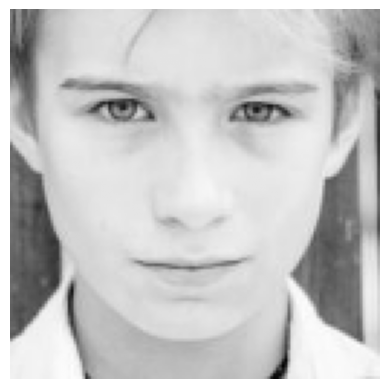

In [31]:
image_index = 200
print("Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_age = round(float(pred[0]))
print("Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

In [20]:
from keras import models

In [21]:
model.save(os.path.join('models', 'ProjectModelIAV1.keras'))